In [1]:
# Import packages ------
import requests
import os
import numpy as np
import pandas as pd
# plotting
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns
# work with dates
from datetime import date

# Change path from code path to data path
#os.getcwd()
path_string = os.getcwd()
path= path_string[:-7]+'1. Data'
#print(path)
# need to change path depending on your computer
os.chdir(path)

# Reuseable Code to make Graphs 

In [3]:
def plot_synth_diff(df, title, y_label, file_name, format_type="percent", treat_time="2022-09"):
    """
    df should contain:
        - 'time_unit': string like '2021-01-01', '2021-02-01', etc. (arbitrary day)
        - 'Percent Diff': numeric column
    treat_time: month of treatment in 'YYYY-MM' format
    """

    df = df.copy()

    # Parse dates (works with 'YYYY-MM-DD')
    df['time_unit'] = pd.to_datetime(df['time_unit'], errors='coerce')
    df = df.dropna(subset=['time_unit'])
    df = df.sort_values('time_unit')

    treat_time_dt = pd.to_datetime(treat_time, format="%Y-%m")

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(
        df['time_unit'],
        df['Percent Diff'],
        marker='o',
        markersize=4,
        linewidth=2,
        color='royalblue',
        label=''
    )

    # Treatment line
    ax.axvline(
        x=treat_time_dt,
        color='crimson',
        linestyle='--',
        linewidth=2,
        label=f'{treat_time_dt.strftime("%b %Y")} (treatment)'
    )

    # Format Y-axis
    if format_type == "percent":
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=1))
    elif format_type == "dollar":
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.2f}'))
    else:
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))

    # Proper X-axis formatting for monthly data
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # every 3 months
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # 'Jan 2021', etc.

    plt.xticks(rotation=45, ha='right')

    # Labels and title
    ax.set_xlabel('Month Year', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()

    plt.tight_layout()
    plt.savefig(f"Graphs/Synth_diff_{file_name}.png", dpi=300)
    plt.show()

In [4]:
def plot_synth(df, title, y_label, file_name, format_type=False, treat_time="2022-09"):
    
    df = df.copy()

    # Parse dates (works with 'YYYY-MM-DD')
    df['time_unit'] = pd.to_datetime(df['time_unit'], errors='coerce')
    df = df.dropna(subset=['time_unit'])
    df = df.sort_values('time_unit')

    treat_time_dt = pd.to_datetime(treat_time, format="%Y-%m")
    
    # Create the main figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the log share on the primary y-axis
    ax.plot(
        df['time_unit'],
        df['real_y'],
        marker='o',
        markersize=5,
        linewidth=2.5,
        color='royalblue', 
        label="Lee County"
    )
    
    ax.plot(
        df['time_unit'],
        df['synth_y'],
        marker='o',
        markersize=5,
        linestyle='--',
        linewidth=2.5,
        color='gray', 
        label="Synthetic Lee County"
    )
    
    # Add vertical line at 2012

     # Treatment line
    ax.axvline(
        x=treat_time_dt,
        color='crimson',
        linestyle='--',
        linewidth=2,
        label=f'{treat_time_dt.strftime("%b %Y")} (treatment)'
    )

    
# Format y-axis based on type
    if format_type == "percent":
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=2))
    elif format_type == "dollar":
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.2f}'))
    else:
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    
    # Proper X-axis formatting for monthly data
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # every 3 months
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # 'Jan 2021', etc.

    plt.xticks(rotation=45, ha='right')

    # Labels and title
    ax.set_xlabel('Month Year', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend()
    
    # Layout and display
    plt.tight_layout()
    plt.savefig("Graphs/Synth_"+file_name+".png", dpi=300)
    plt.show()

In [5]:
def plot_placebo_paths(
    df,
    y_label,
    file_name,
    treated_unit="Lee",
    y_var="difference",
    treat_time="2022-09",
    title=None,
    format_type="percent",
    prune=True,
    prune_ratio=2
):
    """
    Creates an In-Space Placebo plot comparing treated and placebo units.
    """

    df = df.copy()

    # --- Parse and clean dates ---
    df["time_unit"] = pd.to_datetime(df["time_unit"], errors="coerce")
    df = df.dropna(subset=["time_unit"])
    df = df.sort_values("time_unit")

    # --- Treatment time ---
    treat_time_dt = pd.to_datetime(treat_time, format="%Y-%m")

    fig, ax = plt.subplots(figsize=(10, 6))


    # --- Optional pruning based on post/pre RMSPE ratio ---
    if prune and "mspe_ratio" in df.columns:
        df = df[
            (df["unit_name"] == treated_unit) |
            (df["mspe_ratio"] <= 2)
        ]
        
    # # --- Optional pruning based on pre-period RMSPE ---
    # if prune and "pre_rmspe" in df.columns:
    #     treated_rmspe = df.loc[df["unit_name"] == treated_unit, "pre_rmspe"].iloc[0]
    #     cutoff = treated_rmspe * prune_ratio
    #     df = df[
    #         (df["unit_name"] == treated_unit) |
    #         (df["pre_rmspe"] <= cutoff)
    #     ]

    # --- Plot all units ---
    for county, group in df.groupby("unit_name"):
        if county == treated_unit:
            ax.plot(
                group["time_unit"],
                group[y_var],
                color="royalblue",
                linewidth=2.8,
                label=treated_unit,
                zorder=3
            )
        else:
            ax.plot(
                group["time_unit"],
                group[y_var],
                color="lightgray",
                linewidth=1,
                alpha=0.8,
                zorder=1
            )

    # --- Add vertical treatment line ---
    ax.axvline(
        x=treat_time_dt,
        color="crimson",
        linestyle="--",
        linewidth=2,
        label=f"{treat_time_dt.strftime('%b %Y')} (treatment)"
    )

    # --- Add horizontal zero line ---
    ax.axhline(y=0, color="black", linestyle="--", linewidth=1)

    # --- Format Y-axis ---
    if format_type == "percent":
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=2))
    elif format_type == "dollar":
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.2f}"))
    else:
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.2f"))

    # --- Format X-axis ---
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.xticks(rotation=45, ha="right")

    # --- Labels, title, and legend ---
    ax.set_xlabel("Month Year", fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title or f"In-Space Placebo Test for {treated_unit} County", fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.6)
    
    # Custom legend for placebo units only
    ax.plot([], [], color="lightgray", linewidth=1, label="Placebo units")
    ax.legend()
    
    # --- Pruning note ---
    if prune:
        plt.figtext(
            0.5, -0.02,
            f"Placebo units with post-period MSPE to pre-period MSPE > {prune_ratio} were pruned.",
            wrap=True,
            ha="center",
            fontsize=9
        )

    # --- Save and show plot ---
    plt.tight_layout()
    plt.savefig(f"Graphs/Synth_InSpace_Placebos_{file_name}.png", dpi=300, bbox_inches="tight")
    plt.show()

# Results for Synth

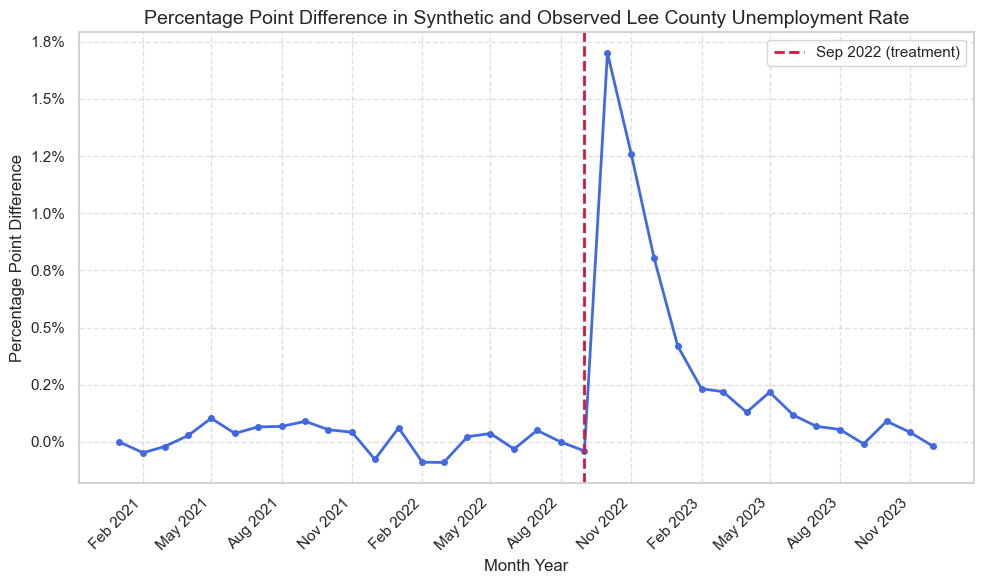

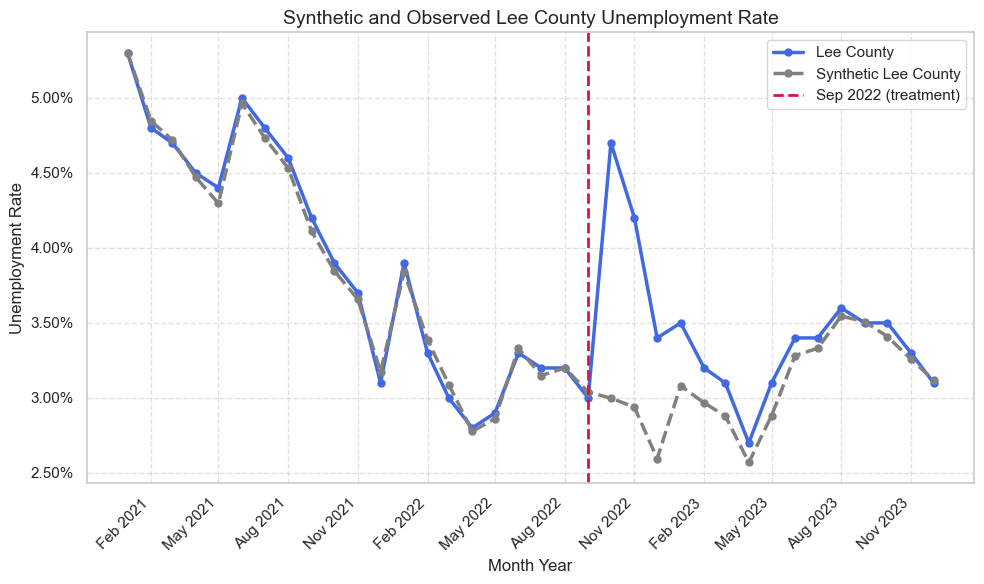

In [25]:
synth_UNR = pd.read_csv("Synth_Results/Synth_Lee_UNR_Results.csv")
synth_UNR['Percent Diff'] = (synth_UNR['real_y'] - synth_UNR['synth_y'])

synth_UNR.head()

plot_synth_diff(synth_UNR, 'Percentage Point Difference in Synthetic and Observed Lee County Unemployment Rate', 'Percentage Point Difference', 'Lee_UNR')

plot_synth(synth_UNR, 'Synthetic and Observed Lee County Unemployment Rate', 'Unemployment Rate', 'Lee_UNR', format_type='percent')

# In-Time Placebos

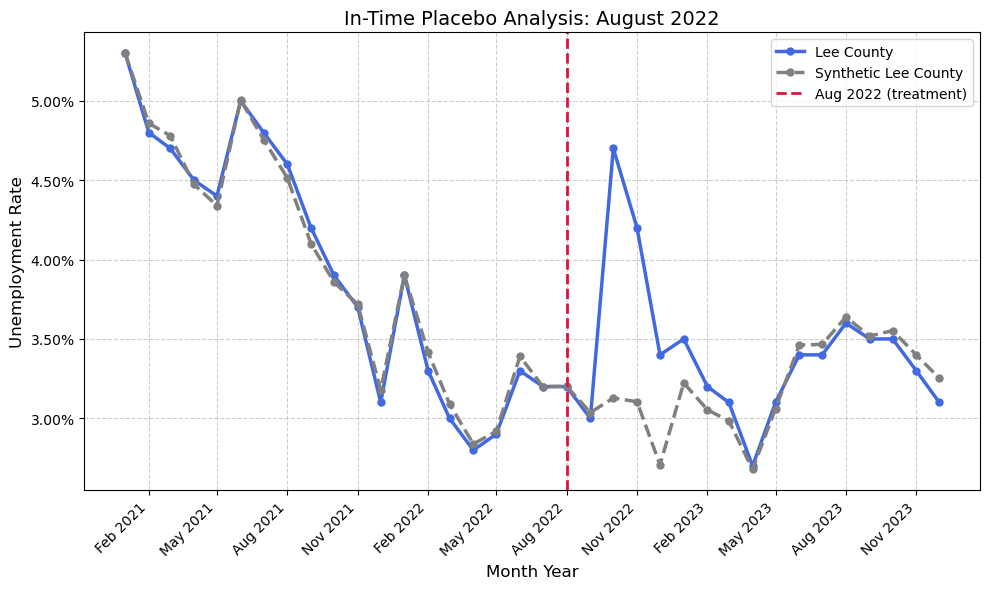

In [9]:
TP_UNR = pd.read_csv("Synth_Results/Synth_In_Time_Placebo_UNR_Results.csv")
TP_UNR['Percent Diff'] = (TP_UNR['real_y'] - TP_UNR['synth_y'])

plot_synth(TP_UNR, 'In-Time Placebo Analysis: August 2022', 'Unemployment Rate', 'In-Time_UNR', format_type='percent', treat_time="2022-08")

# In-Space Placebos

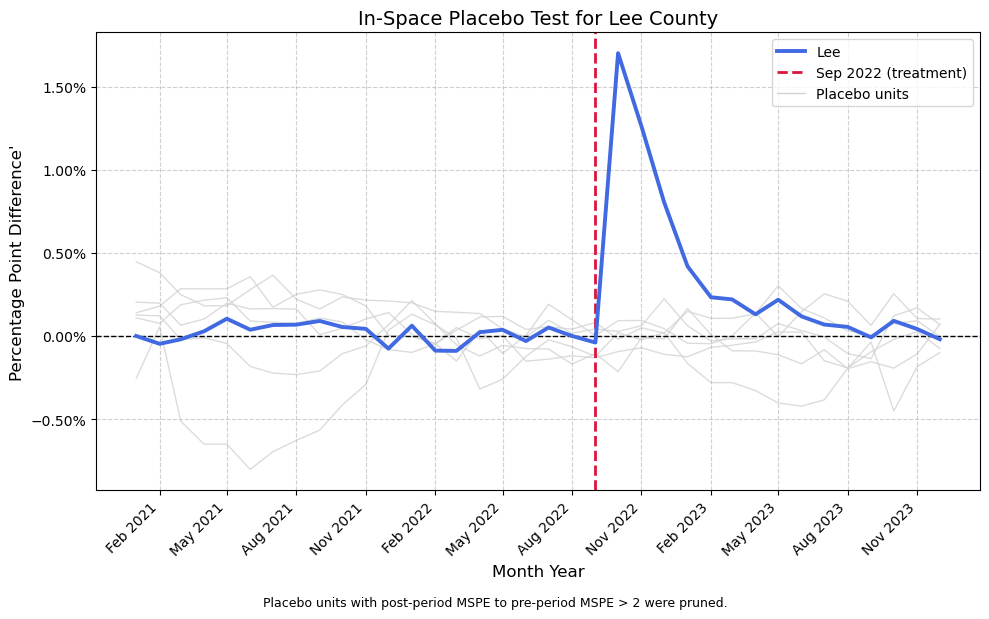

In [11]:
SP_UNR= pd.read_csv("Synth_Results/Synth_In-Space_Placebos_UNR_Results.csv")

plot_placebo_paths(
    df=SP_UNR,
    y_label="Percentage Point Difference'",
    file_name="Lee_UNR",
    treated_unit="Lee",
    y_var="difference",
    treat_time="2022-09",
    prune_ratio=2
)

# RMSPE Bar Graphs

In [13]:
def ratio_rmspe_graph(data_name, file_name):
    df = pd.read_csv("Synth_Results/"+data_name+".csv")
    df['rmspe_ratio'] = np.sqrt(df['post_mspe'])/np.sqrt(df['pre_mspe'])
    # Set style
    sns.set(style="whitegrid")
    
    # Sort by MSPE ratio descending
    df_sorted = df.sort_values("rmspe_ratio", ascending=False)
    
    # Set colors
    palette = {'Donor': 'lightgray', 'Treated': 'royalblue'}
    
    # Plot
    plt.figure(figsize=(10, 6))
    barplot = sns.barplot(
        data=df_sorted,
        y='unit_name',
        x='rmspe_ratio',
        hue='type',
        dodge=False,
        palette=palette
    )
    
    # Labels and title
    plt.xlabel("Post-Period RMSPE / Pre-Period RMSPE", fontsize=12)
    plt.ylabel("")
    plt.title("Ratio of the post-to-pre-intervention period root mean squared predictive error", fontsize=14)
    
    # Remove legend title
    plt.legend(title=None, loc='lower right')
    
    # Tight layout
    plt.tight_layout()
    plt.savefig("Graphs/Ratio_RMSPE_" + file_name + ".png", dpi=300, bbox_inches='tight')
    plt.show()

UNR


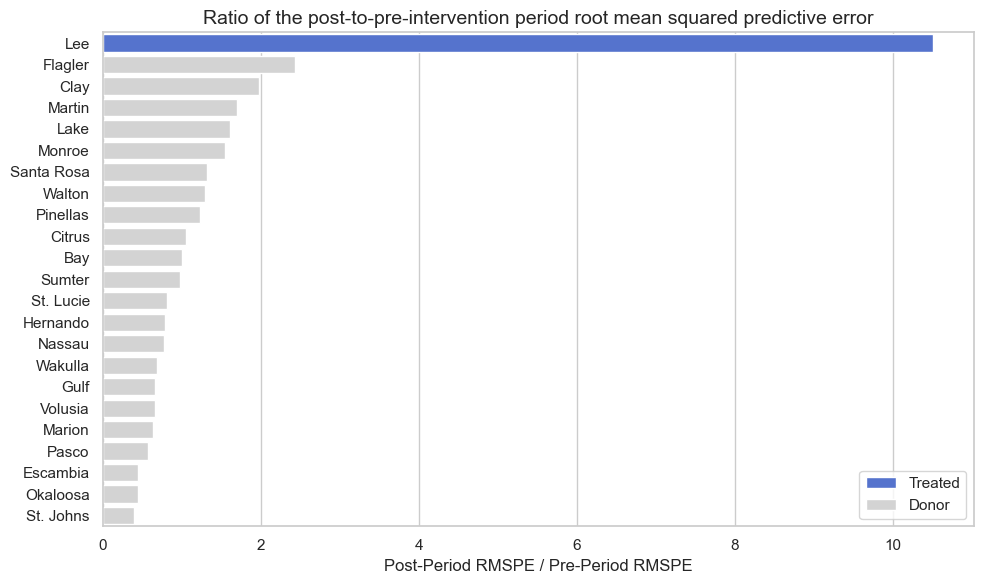

In [14]:
table_name = ['Synth_Lee_UNR_Sig_table']
output_name = ['UNR']

for i in range(len(table_name)):
    print(output_name[i])
    ratio_rmspe_graph(table_name[i], output_name[i])

# County Heat Map